In [ ]:
#Imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from tensorflow import keras
from keras.layers import *
from keras.models import Sequential
from functools import partial
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#List of codons
codon_list = ['UUU','UUC','UUA','UUG','CUU','CUC','CUA','CUG','AUU','AUC','AUA','AUG','GUU','GUC','GUA','GUG','GCU','GCC','GCA','GCG','CCU','CCC','CCA','CCG','UGG','GGU','GGC','GGA','GGG','UCU','UCC','UCA','UCG','AGU','AGC','ACU','ACC','ACA','ACG','UAU','UAC','CAA','CAG','AAU','AAC','UGU','UGC','CAU','CAC','AAA','AAG','CGU','CGC','CGA','CGG','AGA','AGG','GAU','GAC','GAA','GAG','UAA','UAG','UGA']
#Load data
df = pd.read_csv('/content/drive/MyDrive/Logan/ORFs/codon_usage.csv', delimiter = ',')
#Trim out text or missing values
df_trim = df[['Kingdom','DNAtype']+codon_list].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
#Assign to variables
X = df_trim[codon_list].astype(float)
y = df_trim[['Kingdom','DNAtype']].astype(int)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
#Neural Networks
#Function for CV Hyperparameter Optimization
def build_model(n_layers,n_units,l2_pen,d_rate,input_shape=[64]): #standardize this with length of data
    RegularizedDense = partial(
        Dense,
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=keras.regularizers.l2(l2=l2_pen)
    )
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(Dropout(d_rate))
    for layer in range(n_layers):
        model.add(RegularizedDense(n_units))
    model.add(RegularizedDense(n_units / 2))
    model.add(RegularizedDense(n_units / 4))
    model.add(Dense(3,activation='softmax')) #standardize this for length of data as well #3 or 5 depending on the classification
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

#Initialize kerasclassifier
keras_class = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)
#Possible parameters
params_king = {"n_layers": np.arange(1,4,1),
    "n_units": np.arange(500,700,50),
    "l2_pen": np.arange(1e-8,1e-6,1e-7),
    'd_rate': np.arange(0,0.3,0.1)
    }

params_dna = {"n_layers": np.arange(1,10,1),
    "n_units": np.arange(100,1000,100),
    "l2_pen": np.arange(0,1e-4,1e-6),
    'd_rate': np.arange(0,0.5,0.1)
    }
#CV on parameters
grid_king = RandomizedSearchCV(keras_class, params_king, cv = 3, verbose=2, n_iter = 20)
grid_dna = RandomizedSearchCV(keras_class, params_dna, cv = 3, verbose=2, n_iter= 20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
y_king = y['Kingdom']
X_train, X_test, y_train, y_test = train_test_split(X, y_king, test_size=0.2)

#grid_king.fit(X_train, y_train, epochs = 15)
#best_king_model = grid_king.best_estimator_.model

#Split for Kingdom
y_dna = y['DNAtype']
X_train, X_test, y_train, y_test = train_test_split(X, y_dna, test_size=0.2)

grid_dna.fit(X_train, y_train, epochs = 15)
best_dna_model = grid_dna.best_estimator_.model

#print(grid_king.best_params_)
#print(best_king_model.evaluate(X_test,y_test))
print(grid_dna.best_params_)
print(best_dna_model.evaluate(X_test,y_test))

In [ ]:
def metrics(y_pred, y_test):
  auc = roc_auc_score(y_test, y_pred, multi_class= 'ovr')
  y_pred = np.argmax(y_pred,axis=1)
  recall = recall_score(y_test, y_pred, average='weighted')
  precision = precision_score(y_test, y_pred, average='weighted')
  macro_f1 = f1_score(y_test, y_pred, average='macro')
  micro_f1 = f1_score(y_test, y_pred, average='micro')
  accuracy = accuracy_score(y_test, y_pred)
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.show()
  return precision, recall, micro_f1, macro_f1, accuracy, auc

In [ ]:
#Build Best Models from CV
filepath = '/content/drive/MyDrive/Logan/ORFs/kingdom_model.hd5f'

y_king = y['Kingdom']
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y_king), test_size=0.2)

RegularizedDenseK = partial(
    Dense,
    activation='relu',
    kernel_initializer='he_normal',
    kernel_regularizer=keras.regularizers.l2(l2=6.1e-7)
)

king_model = Sequential([
    InputLayer(input_shape=[64]),
    RegularizedDenseK(600),
    RegularizedDenseK(600),
    RegularizedDenseK(300),
    RegularizedDenseK(150),
    Dense(5,activation='softmax')
])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 50,
    restore_best_weights=True
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = filepath,
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)

king_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

king_model.fit(X_train, y_train,
               epochs = 1000,
               validation_split=0.2,
               callbacks=[cp_callback, early_stop],
               shuffle = True)

y_pred = king_model.predict(X_test)
metrics(y_pred, y_test)

In [ ]:
filepath = '/content/drive/MyDrive/Logan/ORFs/dna_model.hd5f'

y_dna = y['DNAtype']
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y_dna), test_size=0.2)

RegularizedDenseD = partial(
    Dense,
    activation='relu',
    kernel_initializer='he_normal',
    kernel_regularizer=keras.regularizers.l2(l2=6.3e-5)
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 50,
    restore_best_weights=True
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = filepath,
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)

dna_model = Sequential([
    InputLayer(input_shape=[64]),
    RegularizedDenseD(700),
    Dropout(0.2),
    RegularizedDenseD(700),
    Dropout(0.2),
    RegularizedDenseD(700),
    Dropout(0.2),
    RegularizedDenseD(700),
    Dropout(0.2),
    RegularizedDenseD(700),
    Dropout(0.2),
    RegularizedDenseD(700),
    Dropout(0.2),
    RegularizedDenseD(350),
    RegularizedDenseD(175),
    Dense(3,activation='softmax')
])

dna_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

dna_model.fit(X_train, y_train,
               epochs = 1000,
               validation_split=0.2,
               callbacks=[cp_callback, early_stop],
               shuffle = True)

y_pred = dna_model.predict(X_test)
metrics(y_pred, y_test)

In [ ]:
#SVM Model
y_king = y['Kingdom']
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y_king), test_size=0.2)

param_grid = {'C': [int(x) for x in np.linspace(start = 100, stop = 300, num = 10)],
              'gamma': [int(x) for x in np.linspace(start = 20, stop = 50, num = 5)],
              }
grid_king = GridSearchCV(svm.SVC(kernel='rbf', decision_function_shape='ovr'), param_grid, cv=5, verbose = 2, n_jobs = -1)
grid_king.fit(X_train, y_train)
print(grid_king.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'C': 100, 'gamma': 42}


In [ ]:
y_dna = y['DNAtype']
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y_dna), test_size=0.2)

param_grid = {'C': [int(x) for x in np.linspace(start = 400, stop = 700, num = 10)],
              'gamma': [int(x) for x in np.linspace(start = 60, stop = 100, num = 10)],
              }
grid_dna = GridSearchCV(svm.SVC(kernel='rbf', decision_function_shape='ovr'), param_grid, cv=5, verbose = 2, n_jobs = -1)
grid_dna.fit(X_train, y_train)
print(grid_dna.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'C': 400, 'gamma': 95}


In [ ]:
y_king = y['Kingdom']
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y_king), test_size=0.2)

best_king_svm = svm.SVC(kernel='rbf', C=144, gamma=50,decision_function_shape='ovr')
best_king_svm.fit(X_train, y_train)
y_pred = best_king_svm.predict(X_test)
onehot = OneHotEncoder(sparse=False)
y_pred_hot = onehot.fit_transform(y_pred.reshape(-1, 1))
metrics(y_pred_hot, y_test)

(0.9676050906286155,
 0.9676050906286155,
 0.9676050906286155,
 0.8936035421540212,
 0.9676050906286155,
 0.9405558948990521)

In [ ]:
y_dna = y['DNAtype']
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y_dna), test_size=0.2)

best_king_svm = svm.SVC(kernel='rbf', C=400, gamma=95, decision_function_shape='ovr')
best_king_svm.fit(X_train, y_train)
y_pred = best_king_svm.predict(X_test)
onehot = OneHotEncoder(sparse=False)
y_pred_hot = onehot.fit_transform(y_pred.reshape(-1, 1))
metrics(y_pred_hot, y_test)

(0.9942151947551099,
 0.9942151947551099,
 0.9942151947551099,
 0.9866043347865082,
 0.9942151947551099,
 0.9886766944365636)

In [ ]:
#Random Forest CV
y_king = y['Kingdom']
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y_king), test_size=0.2)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(rf, random_grid, cv = 3, verbose=2, n_jobs = -1, n_iter = 50)
# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_) #print best paramaters

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': False}


In [ ]:
#Random Forest CV
y_dna = y['DNAtype']
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y_dna), test_size=0.2)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(rf, random_grid, cv = 3, verbose=2, n_jobs = -1, n_iter = 50)
# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_) #print best paramaters

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'n_estimators': 1088, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}


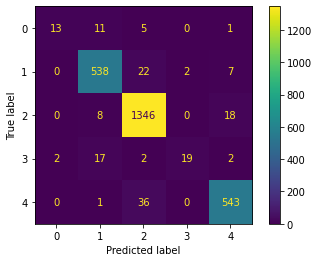

(0.94745135137509,
 0.9483224064789819,
 0.9483224064789819,
 0.8064681324497329,
 0.9483224064789819,
 0.8661499583232756)

In [ ]:
#Ensemble
y_king = y['Kingdom']
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y_king), test_size=0.2)

rnd_clf = RandomForestClassifier(n_estimators=1200,min_samples_split= 2,min_samples_leaf= 1,max_features= 'auto',max_depth= 100,bootstrap=False)
svm_clf = svm.SVC(kernel='rbf', C=144, gamma=50,decision_function_shape='ovr')
knn_clf = KNeighborsClassifier(n_neighbors = 1)

rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
onehot = OneHotEncoder(sparse=False)
y_pred_hot = onehot.fit_transform(y_pred.reshape(-1, 1))
metrics(y_pred_hot, y_test)

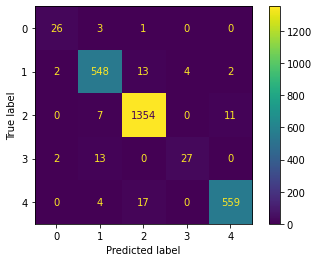

(0.9691367299803891,
 0.9695333590435788,
 0.9695333590435788,
 0.9034295643227608,
 0.9695333590435788,
 0.937497487249256)

In [ ]:
voting_clf = VotingClassifier(
    estimators = [('rf', rnd_clf),('svc', svm_clf),('knn', knn_clf)],
    voting = 'hard')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
onehot = OneHotEncoder(sparse=False)
y_pred_hot = onehot.fit_transform(y_pred.reshape(-1, 1))
metrics(y_pred_hot, y_test)

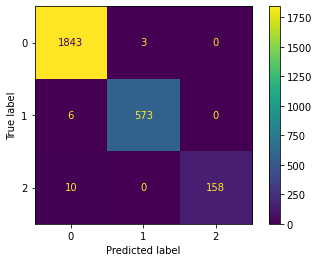

(0.9927097042467753,
 0.9926725800231392,
 0.9926725800231392,
 0.98546824681794,
 0.9926725800231392,
 0.984263296397971)

In [ ]:
y_dna = y['DNAtype']
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y_dna), test_size=0.2)

rnd_clf = RandomForestClassifier(n_estimators=1088,min_samples_split=5,min_samples_leaf= 1,max_features= 'auto',max_depth= None,bootstrap=False)
svm_clf = svm.SVC(kernel='rbf', C=400, gamma=95, decision_function_shape='ovr')
knn_clf = KNeighborsClassifier(n_neighbors = 3)

rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
onehot = OneHotEncoder(sparse=False)
y_pred_hot = onehot.fit_transform(y_pred.reshape(-1, 1))
metrics(y_pred_hot, y_test)

In [ ]:
voting_clf = VotingClassifier(
    estimators = [('rf', rnd_clf),('svc', svm_clf),('knn', knn_clf)],
    voting = 'hard')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
onehot = OneHotEncoder(sparse=False)
y_pred_hot = onehot.fit_transform(y_pred.reshape(-1, 1))
metrics(y_pred_hot, y_test)